In [1]:
!nvidia-smi

Fri Jun 21 10:45:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P6000                 WDDM  | 00000000:03:00.0  On |                 ERR! |
| 26%   43C    P8              14W / 250W |    337MiB / 24576MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [4]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [5]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [7]:
def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        #albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

In [8]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [9]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [10]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [11]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests


processor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-ade-512-512",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         ignore_mismatched_sizes=True
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([6, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpo

device(type='cuda', index=0)

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)
      loss = loss_fn(outputs["logits"], downsampled_labels)
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [16]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)
      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
        
      loss.backward()
      optim.step()
      epoch_loss += loss.item()
      
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-segformer-b1-focal-newaug-batchsize8-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [17]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = smp.losses.FocalLoss(mode="multiclass")
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:06<00:00,  1.46s/it]


Epoch: 1, Loss: 1.9315268043068148


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.396496 | F1-Score: 6.85% | IoU: 4.13% | Precision: 6.79% | Recall: 6.91% | Accuracy: 97.20%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:13<00:00,  1.47s/it]


Epoch: 2, Loss: 0.14590405037085857


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.053772 | F1-Score: 3.91% | IoU: 2.17% | Precision: 34.37% | Recall: 2.26% | Accuracy: 97.91%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:08<00:00,  1.47s/it]


Epoch: 3, Loss: 0.07329912569614187


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.037347 | F1-Score: 8.87% | IoU: 5.35% | Precision: 26.64% | Recall: 5.89% | Accuracy: 98.06%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:01<00:00,  1.45s/it]


Epoch: 4, Loss: 0.041955672456852854


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.032850 | F1-Score: 14.54% | IoU: 9.02% | Precision: 37.90% | Recall: 10.09% | Accuracy: 98.18%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:02<00:00,  1.45s/it]


Epoch: 5, Loss: 0.03575885660886284


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.030585 | F1-Score: 12.36% | IoU: 7.71% | Precision: 39.80% | Recall: 8.55% | Accuracy: 98.19%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 6, Loss: 0.032227157340234805


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.026575 | F1-Score: 19.57% | IoU: 12.62% | Precision: 37.51% | Recall: 14.63% | Accuracy: 98.32%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 7, Loss: 0.028672979249348564


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.024775 | F1-Score: 23.10% | IoU: 15.10% | Precision: 36.24% | Recall: 18.13% | Accuracy: 98.38%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:05<00:00,  1.46s/it]


Epoch: 8, Loss: 0.027386916753265166


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.024032 | F1-Score: 27.38% | IoU: 18.38% | Precision: 35.54% | Recall: 23.20% | Accuracy: 98.42%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:00<00:00,  1.45s/it]


Epoch: 9, Loss: 0.0250755614300649


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.20it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.022266 | F1-Score: 27.00% | IoU: 18.14% | Precision: 57.02% | Recall: 22.18% | Accuracy: 98.48%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:00<00:00,  1.45s/it]


Epoch: 10, Loss: 0.02361456980673416


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.021248 | F1-Score: 28.76% | IoU: 19.47% | Precision: 54.09% | Recall: 23.98% | Accuracy: 98.52%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:04<00:00,  1.46s/it]


Epoch: 11, Loss: 0.022539583812918394


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.020668 | F1-Score: 34.26% | IoU: 24.21% | Precision: 53.16% | Recall: 32.28% | Accuracy: 98.55%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:10<00:00,  1.47s/it]


Epoch: 12, Loss: 0.02191553473953278


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.019721 | F1-Score: 35.75% | IoU: 25.48% | Precision: 53.28% | Recall: 33.63% | Accuracy: 98.58%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 13, Loss: 0.020785464206710458


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.019081 | F1-Score: 35.68% | IoU: 25.27% | Precision: 56.48% | Recall: 31.61% | Accuracy: 98.61%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 14, Loss: 0.019853450978294978


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.018627 | F1-Score: 39.21% | IoU: 27.60% | Precision: 56.48% | Recall: 33.96% | Accuracy: 98.62%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 15, Loss: 0.019237296594186656


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017958 | F1-Score: 41.45% | IoU: 29.33% | Precision: 73.03% | Recall: 36.26% | Accuracy: 98.65%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:02<00:00,  1.46s/it]


Epoch: 16, Loss: 0.01858903938198402


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.017508 | F1-Score: 47.51% | IoU: 33.90% | Precision: 74.11% | Recall: 41.68% | Accuracy: 98.68%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [14:56<00:00,  1.45s/it]


Epoch: 17, Loss: 0.01806591932376426


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.017214 | F1-Score: 53.66% | IoU: 38.54% | Precision: 71.02% | Recall: 48.35% | Accuracy: 98.70%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [14:57<00:00,  1.45s/it]


Epoch: 18, Loss: 0.017610574609810307


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.017051 | F1-Score: 51.94% | IoU: 37.30% | Precision: 72.22% | Recall: 44.98% | Accuracy: 98.70%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [14:55<00:00,  1.45s/it]


Epoch: 19, Loss: 0.017125197265657685


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.016726 | F1-Score: 59.94% | IoU: 43.33% | Precision: 70.05% | Recall: 53.14% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [14:57<00:00,  1.45s/it]


Epoch: 20, Loss: 0.016687520706815825


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.016578 | F1-Score: 58.37% | IoU: 41.83% | Precision: 72.60% | Recall: 50.08% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [14:58<00:00,  1.45s/it]


Epoch: 21, Loss: 0.01640283211675142


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.016513 | F1-Score: 62.16% | IoU: 45.50% | Precision: 70.79% | Recall: 56.49% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:00<00:00,  1.45s/it]


Epoch: 22, Loss: 0.01622943251183437


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.016248 | F1-Score: 62.94% | IoU: 46.26% | Precision: 70.31% | Recall: 57.61% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:02<00:00,  1.46s/it]


Epoch: 23, Loss: 0.015846894346478006


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.20it/s]


Validation: Loss: 0.016542 | F1-Score: 63.55% | IoU: 46.84% | Precision: 69.70% | Recall: 58.80% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:02<00:00,  1.46s/it]


Epoch: 24, Loss: 0.015723749766907383


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017008 | F1-Score: 58.87% | IoU: 42.21% | Precision: 73.70% | Recall: 49.50% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:06<00:00,  1.46s/it]


Epoch: 25, Loss: 0.015314009238875681


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.258082 | F1-Score: 43.52% | IoU: 30.51% | Precision: 32.70% | Recall: 84.65% | Accuracy: 93.73%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:05<00:00,  1.46s/it]


Epoch: 26, Loss: 0.015203116247580657


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.20it/s]


Validation: Loss: 0.016459 | F1-Score: 64.47% | IoU: 47.77% | Precision: 71.75% | Recall: 58.95% | Accuracy: 98.77%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:03<00:00,  1.46s/it]


Epoch: 27, Loss: 0.014921943780275122


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.20it/s]


Validation: Loss: 0.016224 | F1-Score: 62.97% | IoU: 46.24% | Precision: 73.04% | Recall: 55.75% | Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:02<00:00,  1.46s/it]


Epoch: 28, Loss: 0.014898717222404816


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.016512 | F1-Score: 63.85% | IoU: 47.05% | Precision: 73.46% | Recall: 56.62% | Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:06<00:00,  1.46s/it]


Epoch: 29, Loss: 0.014866186878005524


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.016458 | F1-Score: 65.91% | IoU: 49.32% | Precision: 69.07% | Recall: 63.38% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:03<00:00,  1.46s/it]


Epoch: 30, Loss: 0.014335009575851501


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.017013 | F1-Score: 63.58% | IoU: 46.75% | Precision: 73.13% | Recall: 56.39% | Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:14<00:00,  1.47s/it]


Epoch: 31, Loss: 0.014093835443829096


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.019398 | F1-Score: 59.60% | IoU: 42.91% | Precision: 74.63% | Recall: 50.68% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:17<00:00,  1.48s/it]


Epoch: 32, Loss: 0.014010198283640127


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.16it/s]


Validation: Loss: 0.018353 | F1-Score: 61.10% | IoU: 44.33% | Precision: 75.20% | Recall: 52.25% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:14<00:00,  1.47s/it]


Epoch: 33, Loss: 0.013981871457109529


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017237 | F1-Score: 65.16% | IoU: 48.51% | Precision: 70.61% | Recall: 60.74% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:15<00:00,  1.48s/it]


Epoch: 34, Loss: 0.014212657943473107


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.017410 | F1-Score: 63.44% | IoU: 46.66% | Precision: 73.98% | Recall: 55.95% | Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:20<00:00,  1.49s/it]


Epoch: 35, Loss: 0.013639209376678112


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.16it/s]


Validation: Loss: 0.018023 | F1-Score: 63.84% | IoU: 47.08% | Precision: 73.47% | Recall: 56.76% | Accuracy: 98.77%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 36, Loss: 0.014124269808282054


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.022957 | F1-Score: 43.34% | IoU: 28.45% | Precision: 83.87% | Recall: 30.36% | Accuracy: 98.61%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:07<00:00,  1.46s/it]


Epoch: 37, Loss: 0.013737460514230113


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.023304 | F1-Score: 53.01% | IoU: 36.21% | Precision: 80.17% | Recall: 39.80% | Accuracy: 98.59%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:05<00:00,  1.46s/it]


Epoch: 38, Loss: 0.013330271911446846


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.039388 | F1-Score: 14.70% | IoU: 8.59% | Precision: 83.71% | Recall: 8.81% | Accuracy: 98.22%


100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [15:09<00:00,  1.47s/it]


Epoch: 39, Loss: 0.01407555686798127


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:13<00:00,  1.21it/s]


Validation: Loss: 0.027805 | F1-Score: 43.38% | IoU: 29.07% | Precision: 80.36% | Recall: 32.07% | Accuracy: 98.64%


  8%|██████▌                                                                          | 50/620 [01:14<14:14,  1.50s/it]


KeyboardInterrupt: 

In [18]:
best_model = torch.load('model-segformer-b1-focal-newaug-batchsize8-2024-06-21.pt')
best_model = best_model.to(device)

In [19]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:36<00:00,  1.24it/s]


In [20]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.728618,0.573092,0.725480,0.731785
2,0.654998,0.486987,0.633148,0.678410
3,0.709033,0.549226,0.705765,0.712331
4,0.661188,0.493862,0.692573,0.632525
5,0.562207,0.391021,0.664207,0.487365


In [22]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 66.32%
IoU: 49.88%
Precision: 68.42%
Recall: 64.85%
Overall Accuracy: 98.77%


In [23]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

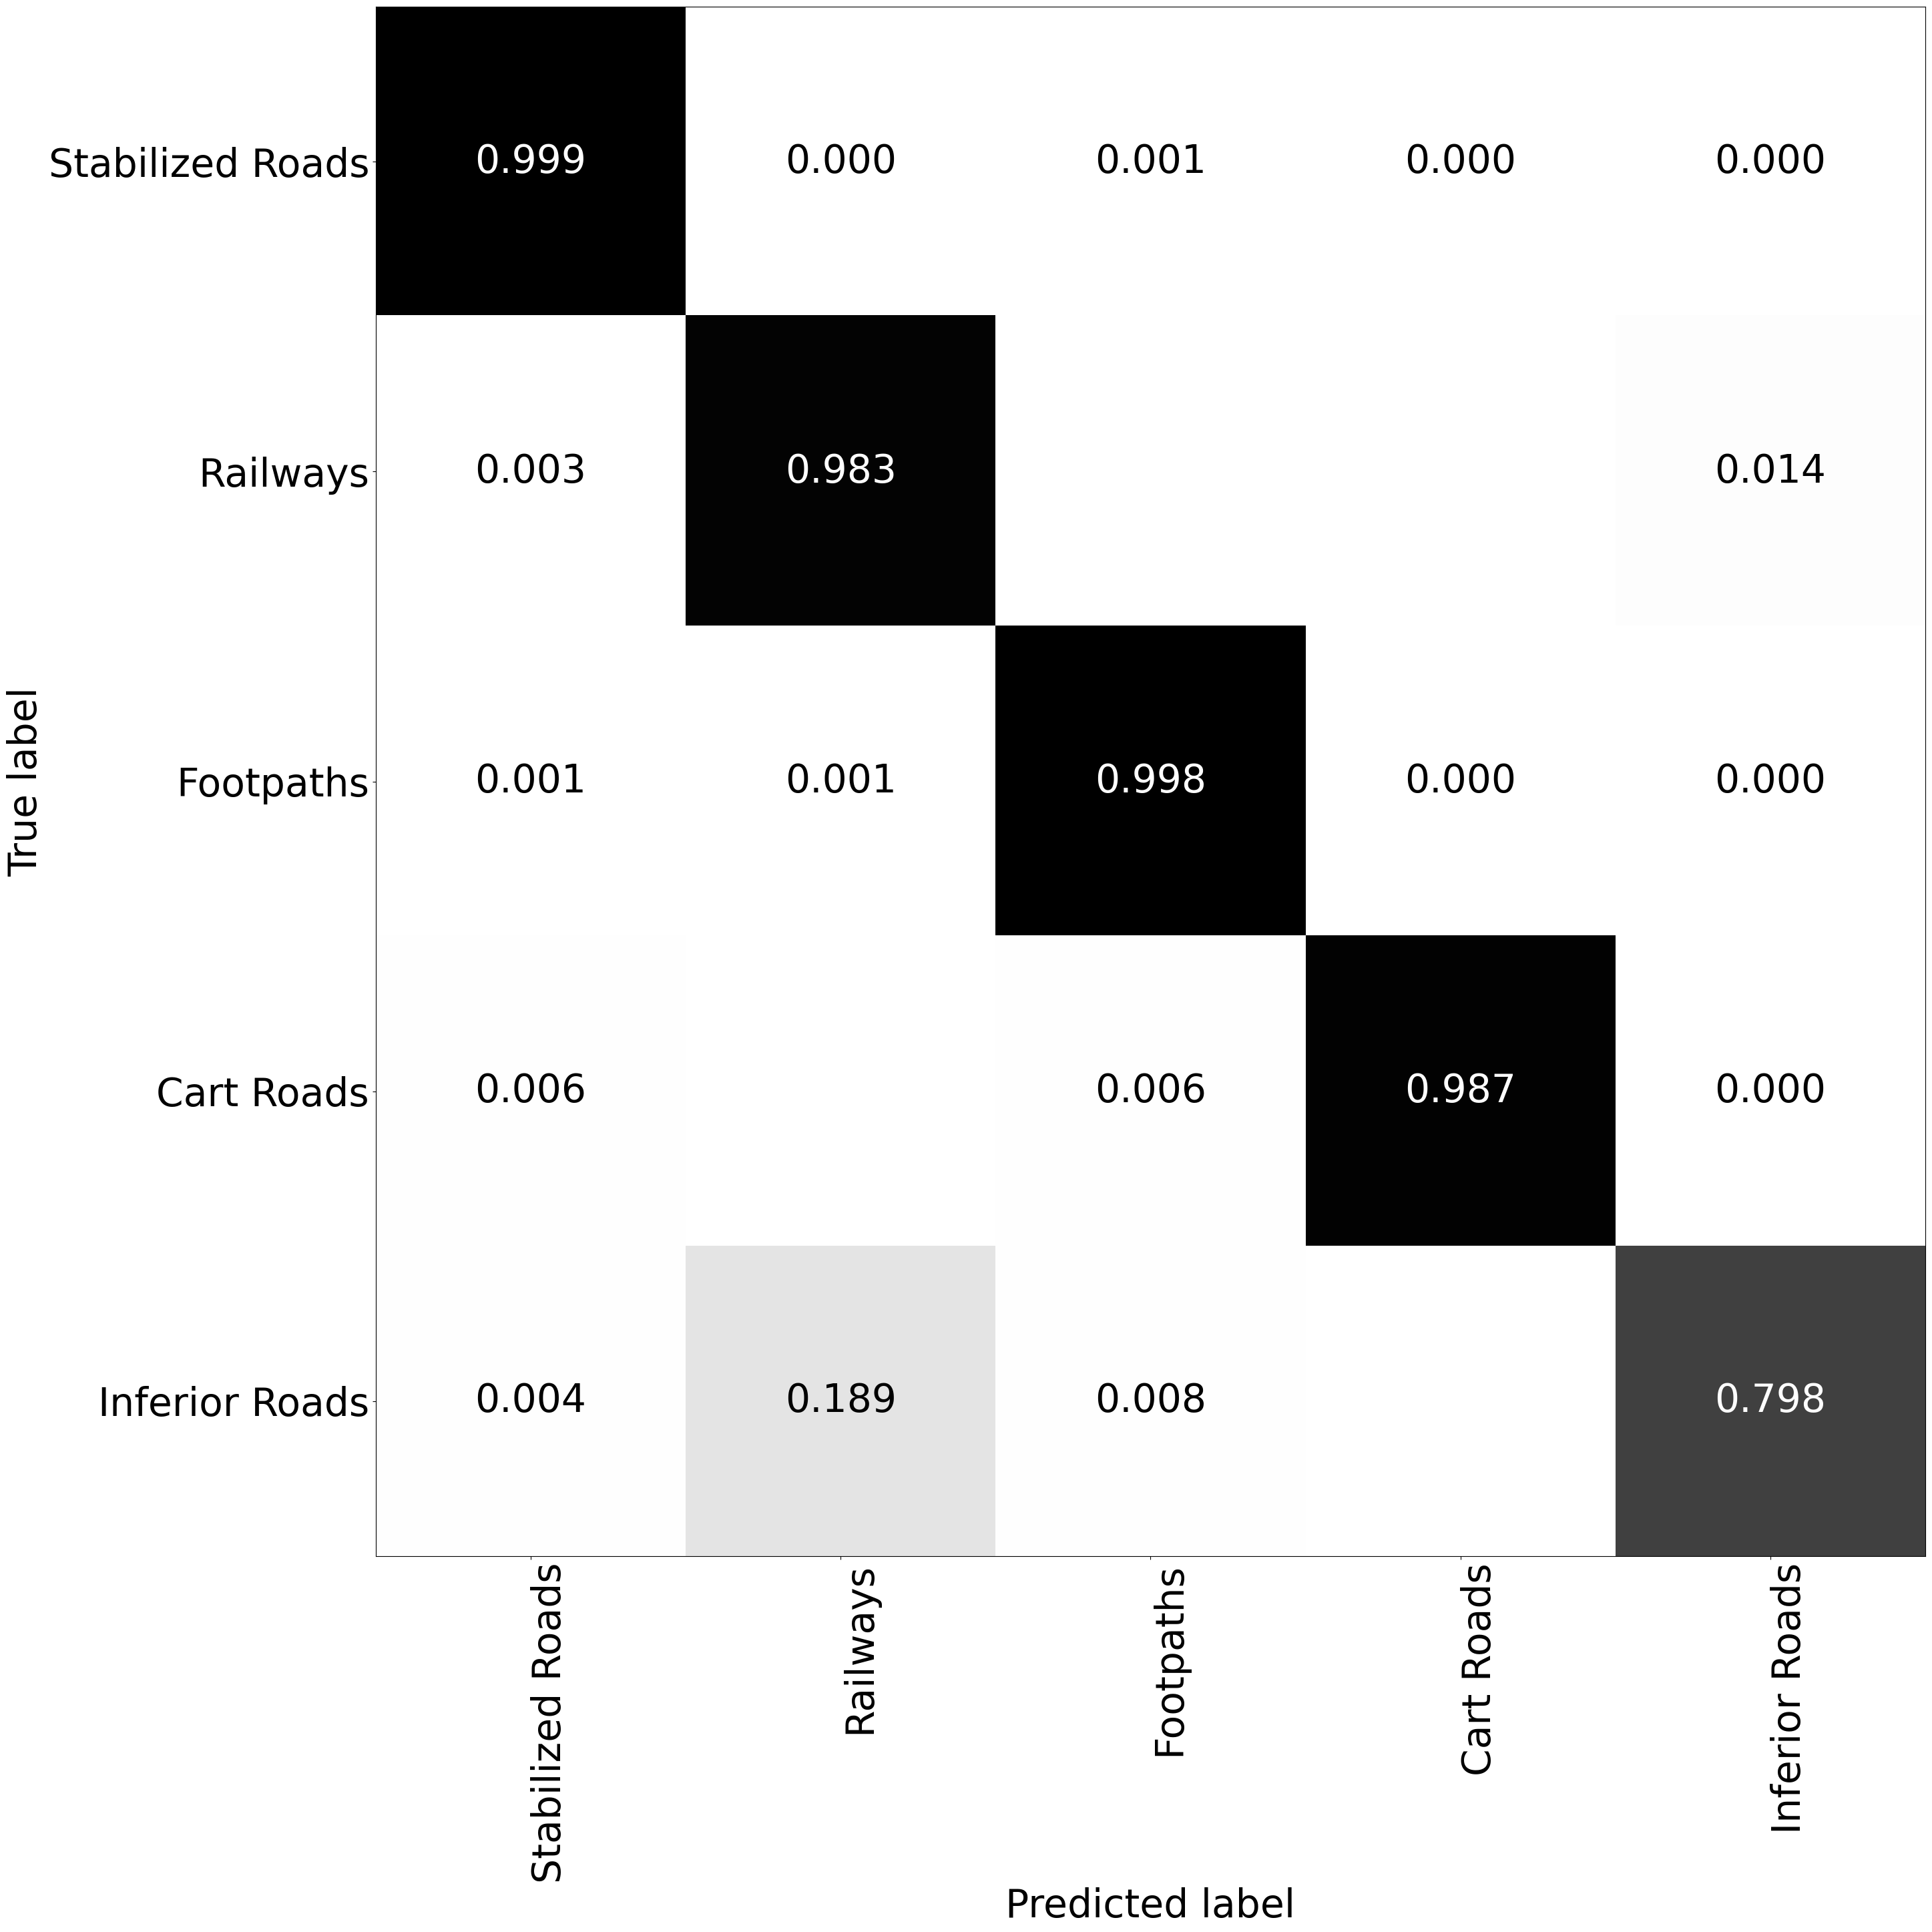

In [25]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [23]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


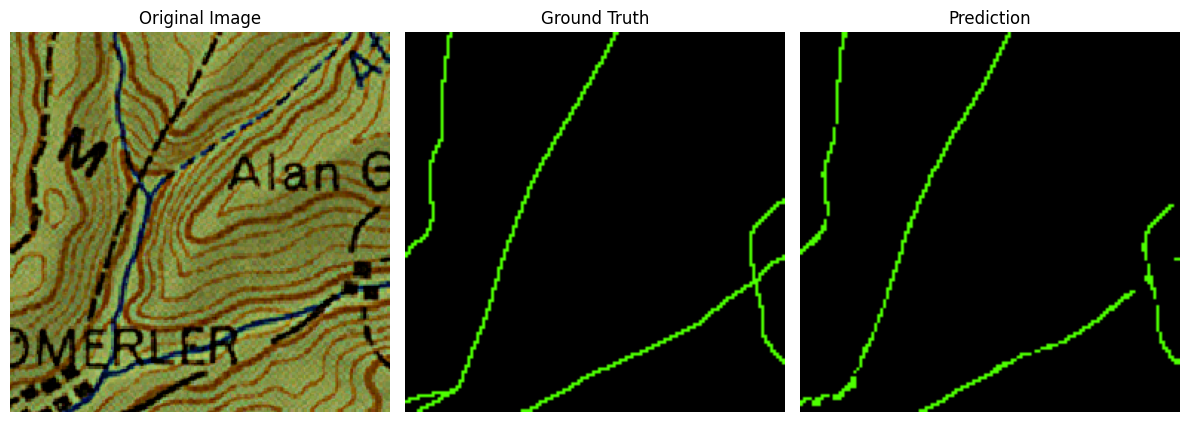

In [31]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
